In [2]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from typing import List

%matplotlib inline

In [3]:
DATASET_PATH = os.path.join("..", "dataset", "archive") 
LABELS = []

In [4]:
samples = []
for directory in os.listdir(DATASET_PATH):
  if os.path.isdir(os.path.join(DATASET_PATH, directory)):
    LABELS.append(directory)
    files = os.listdir(os.path.join(DATASET_PATH, directory))
    samples.append((os.path.join(DATASET_PATH, directory, files[0]), directory))
LABELS

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

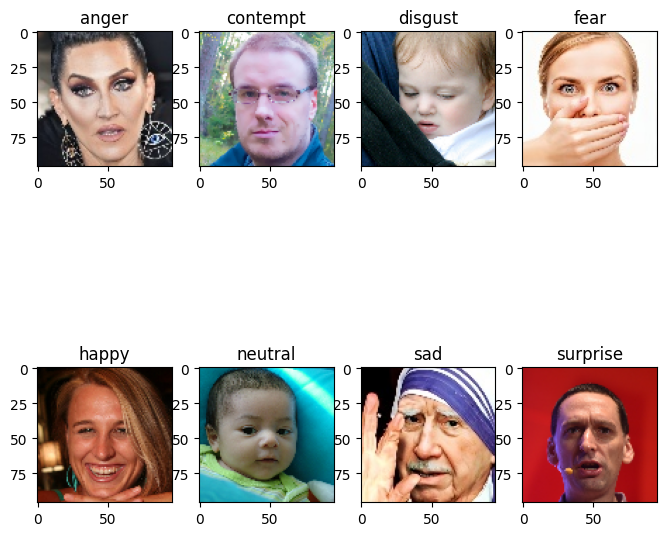

In [5]:
fig = plt.figure(figsize=(8, 8))
rows = 2
columns = 4
for i in range(1, columns*rows + 1):
  ax = plt.subplot(rows, columns, i)
  ax.set_title(samples[i-1][1])
  img = np.asarray(Image.open(samples[i-1][0]))
  ax.imshow(img)
plt.show()

(96, 96, 3)


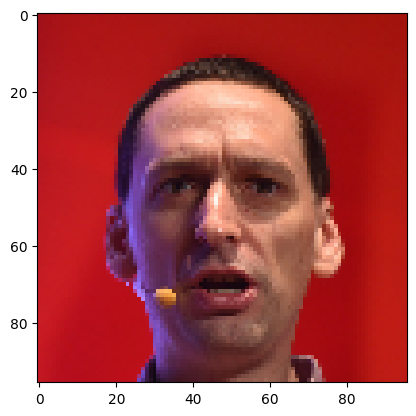

In [6]:
test_img = np.copy(img)
print(test_img.shape)
plt.imshow(test_img)

96 x 96 images, so we can start with 144 (12 * 12) patches of size 8 x 8 

In [7]:
IMG_SIZE = 96
PATCH_SIZE = 8
NB_PATCH_SQRT = IMG_SIZE // PATCH_SIZE

In [8]:
def draw_patches(img: np.array) -> np.array:
  image = np.copy(img)
  for i in range(0, NB_PATCH_SQRT):
    for j in range(0, NB_PATCH_SQRT, 2):
      if i % 2 == 0:
        image[i * PATCH_SIZE : (i + 1) * PATCH_SIZE, j * PATCH_SIZE : (j + 1) * PATCH_SIZE] = image[i * PATCH_SIZE : (i + 1) * PATCH_SIZE, j * PATCH_SIZE : (j + 1) * PATCH_SIZE] / 2
      else:
        image[i * PATCH_SIZE : (i + 1) * PATCH_SIZE, (j + 1) * PATCH_SIZE : (j + 2) * PATCH_SIZE] = image[i * PATCH_SIZE : (i + 1) * PATCH_SIZE, (j + 1) * PATCH_SIZE : (j + 2) * PATCH_SIZE] / 2
  return image

Patch representation on sample image

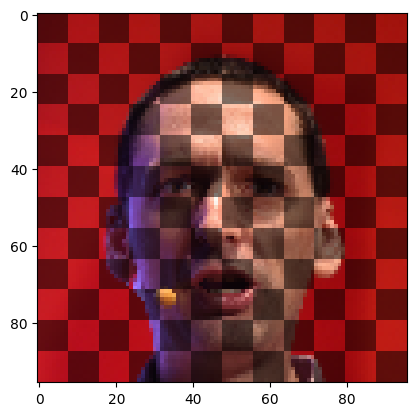

In [9]:
plt.imshow(draw_patches(test_img))

In [10]:
def random_mask_on_pixels(img: np.array) -> np.array:
  image = np.copy(img)
  aspect_ratio_range = [0.75, 1.5]
  scale_range = [0.15, 0.2]

  ar = np.random.uniform(*aspect_ratio_range)
  s = np.random.uniform(*scale_range)

  area = s * (IMG_SIZE ** 2)
  height = int(round(np.sqrt(area / ar)))
  width = int(round(np.sqrt(area * ar)))

  x, y = np.random.randint(low=IMG_SIZE - width + 1), np.random.randint(low=IMG_SIZE - height + 1)

  image[y : y + height, x : x + width] = image[y : y + height, x : x + width] / 2
  return image

In [11]:
def show_patch_corner(img: np.array) -> np.array:
  image = np.copy(img)
  for i in range(0, NB_PATCH_SQRT):
    for j in range(0, NB_PATCH_SQRT):
      image[i * PATCH_SIZE, j * PATCH_SIZE] = np.array([255, 255, 255])
  return image

Single mask (pixel level) on sample image

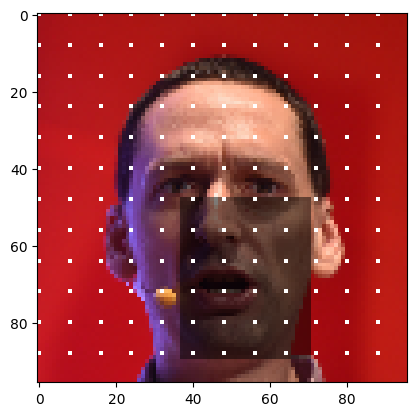

In [12]:
plt.imshow(show_patch_corner(random_mask_on_pixels(test_img)))

In [13]:
def random_mask_on_patch(img: np.array, aspect_ratio_range: List[float] = [0.75, 1.5], scale_range: List[float] = [0.15, 0.2]) -> np.array:
  image = np.copy(img)

  ar = np.random.uniform(*aspect_ratio_range)
  s = np.random.uniform(*scale_range)

  area = s * (NB_PATCH_SQRT ** 2)
  height = int(round(np.sqrt(area / ar)))
  width = int(round(np.sqrt(area * ar)))

  x, y = np.random.randint(low=NB_PATCH_SQRT - width + 1), np.random.randint(low=NB_PATCH_SQRT - height + 1)

  image[y * PATCH_SIZE : (y + height) * PATCH_SIZE, x * PATCH_SIZE : (x + width) * PATCH_SIZE] = image[y * PATCH_SIZE : (y + height) * PATCH_SIZE, x * PATCH_SIZE : (x + width) * PATCH_SIZE] / 2
  mask_indexes = torch.cat([torch.arange(x, x + width) + i * NB_PATCH_SQRT for i in range(y, y + height)])

  return image, (x, y, width, height, mask_indexes)

Single mask (patch level) on sample image, this is the mask we will keep to **train** our model

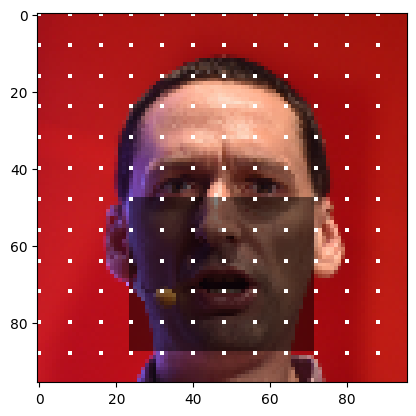

In [14]:
plt.imshow(show_patch_corner(random_mask_on_patch(test_img)[0]))

In [15]:
def M_mask(img: np.array, M: int = 4) -> np.array:
  image = np.copy(img)
  masks = []

  for _ in range(M):
    image, mask_info = random_mask_on_patch(image)
    masks.append(mask_info)
    print(mask_info)

  return image

Multiple (4 as stated in the paper) masks on sample image

(1, 2, 6, 4, tensor([25, 26, 27, 28, 29, 30, 37, 38, 39, 40, 41, 42, 49, 50, 51, 52, 53, 54,
        61, 62, 63, 64, 65, 66]))
(0, 5, 5, 5, tensor([ 60,  61,  62,  63,  64,  72,  73,  74,  75,  76,  84,  85,  86,  87,
         88,  96,  97,  98,  99, 100, 108, 109, 110, 111, 112]))
(5, 3, 6, 4, tensor([41, 42, 43, 44, 45, 46, 53, 54, 55, 56, 57, 58, 65, 66, 67, 68, 69, 70,
        77, 78, 79, 80, 81, 82]))
(6, 4, 5, 5, tensor([ 54,  55,  56,  57,  58,  66,  67,  68,  69,  70,  78,  79,  80,  81,
         82,  90,  91,  92,  93,  94, 102, 103, 104, 105, 106]))


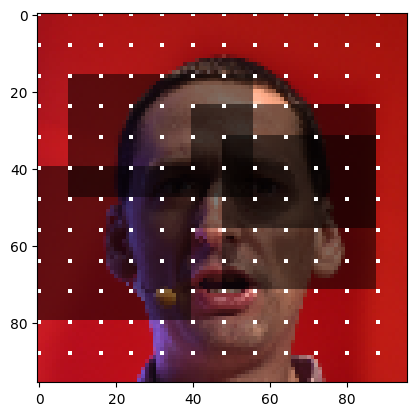

In [16]:
plt.imshow(show_patch_corner(M_mask(test_img)))

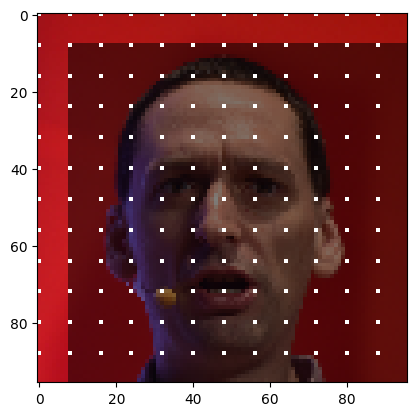

In [17]:
plt.imshow(show_patch_corner(random_mask_on_patch(test_img, scale_range=[0.85, 1], aspect_ratio_range=[1,1])[0]))

In [18]:
def mask_and_context(img: np.array, M: int = 4): 
  image = np.copy(img)
  indexes_masks = set()
  fig = plt.figure(figsize=(20, 12))

  for _ in range(M):
    image, mask_info = random_mask_on_patch(image)
    indexes_masks.update(mask_info[4].tolist())

  image_context, mask_context = random_mask_on_patch(np.copy(img), scale_range=[0.85, 1], aspect_ratio_range=[1,1])
  indexes_context = set(mask_context[4].tolist())

  fig.add_subplot(1, 3, 1)
  plt.imshow(image)
  fig.add_subplot(1, 3, 2)
  plt.imshow(image_context)

  final_indexes = indexes_context - indexes_masks
  image_final_context = np.copy(img)
  for i in final_indexes:
    image_final_context[(i // NB_PATCH_SQRT) * PATCH_SIZE : (i // NB_PATCH_SQRT + 1) * PATCH_SIZE, (i % NB_PATCH_SQRT) * PATCH_SIZE : (i % NB_PATCH_SQRT + 1) * PATCH_SIZE] = image_final_context[(i // NB_PATCH_SQRT) * PATCH_SIZE : (i // NB_PATCH_SQRT + 1) * PATCH_SIZE, (i % NB_PATCH_SQRT) * PATCH_SIZE : (i % NB_PATCH_SQRT + 1) * PATCH_SIZE] // 2

  fig.add_subplot(1, 3, 3)
  plt.imshow(image_final_context)
  
  plt.show()

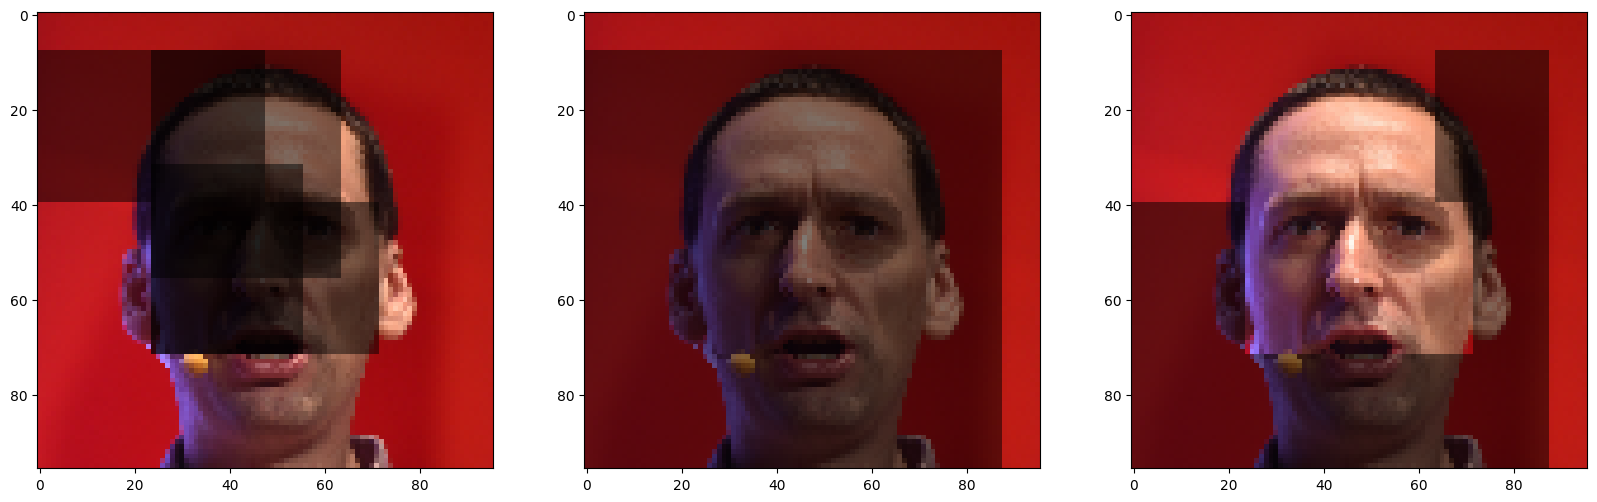

In [33]:
mask_and_context(test_img)